In [1]:
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import matplotlib.colors as colors
from cnmaps import get_adm_maps, draw_maps
import cmaps
from toolbar.masked import masked   # 气象工具函数
from toolbar.significance_test import *
import pandas as pd
import tqdm
import seaborn as sns
from scipy import stats

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cnmaps\__init__.py:23: UserWarning: 由于Shapely的版本高于2.0.0, 请将Shapely的版本降级到2.0.0以下, 否则会影响功能的使用
  warnings.warn(("由于Shapely的版本高于2.0.0, 请将Shapely的版本降级到2.0.0以下, 否则会影响功能的使用"))


In [5]:
xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc").to_numpy()

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [2]:
# 数据读取
time = [1961, 2022]
EHDstations_zone = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
T_th = 0.90
t95 = masked(EHDstations_zone, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").mean(dim=['year', 'day']).quantile(T_th)  # 夏季内 长江中下游流域 分位数
EHD = EHDstations_zone - t95
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
zone_stations = masked((CN051_2 - CN051_2 + 1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
EHDstations_zone.name = 'EHS'

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


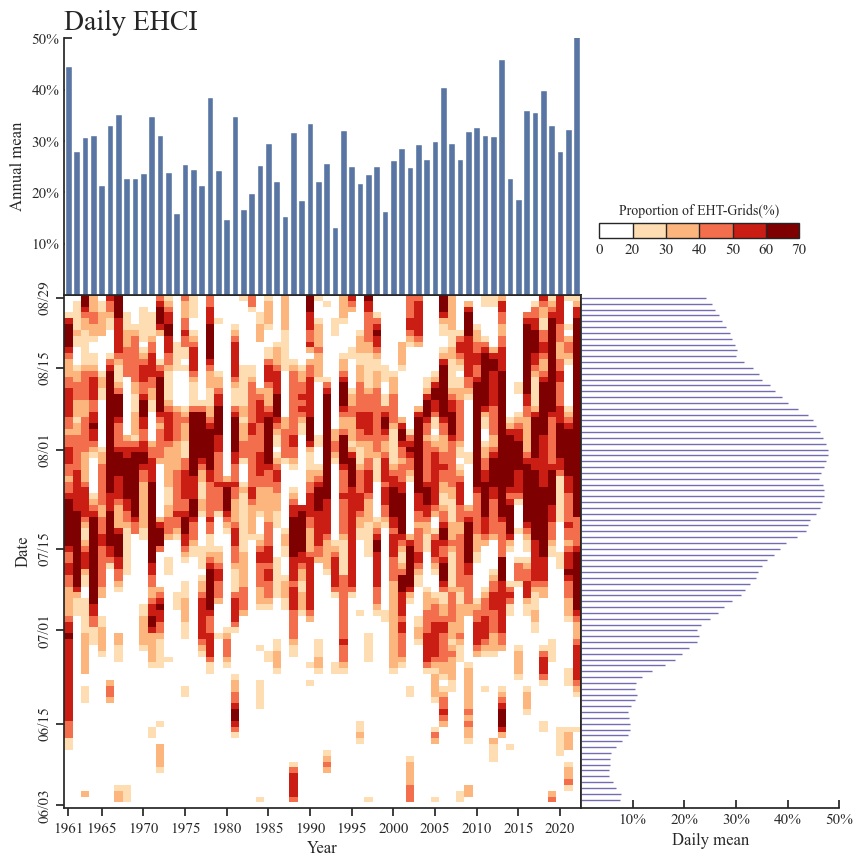

In [3]:
# 绘图
sns.set(style='ticks')
# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure()
fig.subplots_adjust(wspace=0, hspace=0)  # 调整子图间距
spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[2, 1], height_ratios=[1, 2])  # 设置子图比例

# 自定义色标 (https://mp.weixin.qq.com/s/X3Yi1NGncoB39Lm0UMTLMQ)
bins = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
custom_colors = ["#FFFFFF", "#FDDDB1", "#FDB57E", "#F26E4c", "#CA1E14", "#7F0000"]
custom_cmap = colors.ListedColormap(custom_colors)
norm = colors.BoundaryNorm(bins, custom_cmap.N)
ax1 = sns.heatmap(EHDstations_zone.to_numpy().T, cmap=custom_cmap, norm=norm, ax=fig.add_subplot(spec[1, 0]), cbar=False)  # 长江流域极端高温格点逐日占比热力图
ax1.invert_yaxis()  # 热力图y轴反向

##设置ax1坐标##
# ax1.collections[0].colorbar.remove()  # 隐藏ax1的色标colormap
ax = plt.gca()
# 设置横坐标的刻度范围和标记
x = np.arange(time[0], time[1] + 1, 1)
ax.set_xlim(0, time[1] - time[0] + 1)
ax.set_xticks([0.5, 4.5, 9.5, 14.5, 19.5, 24.5, 29.5, 34.5, 39.5, 44.5, 49.5, 54.5, 59.5])
ax.set_xticklabels(["1961", "1965", "1970", "1975", "1980", "1985", "1990", "1995", "2000", "2005", "2010", "2015", "2020"], rotation=0)
# 设置纵坐标的刻度范围和标记
y = np.arange(0, 91, 1)
ax.set_ylim(0, 88)
ax.set_yticks([0.5, 14.5, 30.5, 44.5, 61.5, 75.5, 87.5])
ax.set_yticklabels(["06/03", "06/15", "07/01", "07/15", "08/01", "08/15", "08/29"])
ax.spines['top'].set_visible(True)  # 显示上边框
ax.spines['right'].set_visible(True)  # 显示右边框
ax.spines['bottom'].set_visible(True)  # 显示下边框
ax.spines['left'].set_visible(True)  # 显示左边框
plt.xlabel('Year')
plt.ylabel('Date')
# 设置色标
ax_cbar = fig.add_axes([0.66, 0.68, 0.20, 0.015])
cbar = plt.colorbar(ax1.collections[0], cax=ax_cbar, orientation='horizontal', drawedges=True)
cbar.set_ticklabels(["0", "20", "30", "40", "50", "60", "70"])
cbar.ax.set_title('Proportion of EHT-Grids(%)', fontsize=10)
cbar.ax.tick_params(length=0)  # 设置色标刻度长度
cbar.dividers.set_linewidth(1.0)  # 设置分割线宽度
cbar.outline.set_linewidth(1.0)  # 设置色标轮廓宽度
##设置ax1坐标结束##

ax2 = sns.barplot(data=EHDstations_zone.mean('day').to_dataframe()*100, x="year", y="EHS", ax=fig.add_subplot(spec[0, 0]), errorbar=('ci', 0))  # 长江流域极端高温格点逐日占比
##设置ax2坐标##
ax2.xaxis.set_visible(False)  # ax2隐藏x轴标签
ax = plt.gca()
ax.set_xlim(-.5, time[1] - time[0] + 1 - .5)
ax.set_ylim(0, 0.5*100)
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels(["10%", "20%", "30%", "40%", "50%"])
ax.tick_params(axis='y', direction='in')  # 设置y轴刻度方向
ax.spines['top'].set_visible(False)  # 隐藏上边框
ax.spines['right'].set_visible(False)  # 隐藏右边框
ax.spines['bottom'].set_visible(True)  # 显示下边框
ax.spines['left'].set_visible(True)  # 显示左边框
plt.ylabel('Annual mean')
ax.set_title('Daily EHCI', fontsize=20, loc='left')
##设置ax2坐标结束##

# ax2_reg = ax2.twinx()
# ax2_reg = sns.regplot(data=EHDstations_zone.mean('day').to_dataframe()*100, x=[i for i in range(time[1] - time[0] + 1)], y="EHS", ax=ax2_reg, scatter=False, color='#74C476')  # 长江流域极端高温格点逐年占比
# # 计算原数据是否符合正态分布,回归的斜率、截距、相关系数、p 值等
# #p = normal_test(EHDstations_zone.mean('day').data[0])[1]
# slope, intercept, r_value, p_value, std_err = stats.linregress([i for i in range(time[1] - time[0] + 1)], EHDstations_zone.mean('day')*100)
# ##设置ax2_reg坐标##
# ax2_reg.yaxis.set_visible(False)  # ax2隐藏y轴标签
# ax = plt.gca()
# ax.set_ylim(0, 0.5*100)
# ax.spines['top'].set_visible(False)  # 隐藏上边框
# ax.spines['right'].set_visible(False)  # 隐藏右边框
# ax.spines['bottom'].set_visible(False)  # 显示下边框
# ax.spines['left'].set_visible(False)  # 显示左边框

##设置ax2_reg坐标结束##

ax3 = sns.barplot(data=EHDstations_zone.to_dataframe()*100, x="EHS", y='day', orient='h', ax=fig.add_subplot(spec[1, 1]), errorbar=('ci', 0), width=0, color='None', edgecolor='#756BB1')  # 长江流域极端高温格点逐日占比
#ax3_6_line = plt.axvline(x=EHDstations_zone.mean('year').to_dataframe()[:30].mean().to_numpy()*100, ymax=30/92, color='#74C476', linestyle='-')  # 添加50%置信度分割线
#ax3_78_line = plt.axvline(x=EHDstations_zone.mean('year').to_dataframe()[30:].mean().to_numpy()*100, ymin=30/92, color="#CA1E14", linestyle='-')
##设置ax3坐标##
ax3.yaxis.set_visible(False)  # ax3隐藏y轴标签
ax = plt.gca()
ax.set_xlim(0, 0.5*100)
ax.set_xticks([10, 20, 30, 40, 50])
ax.set_xticklabels([ "10%", "20%", "30%", "40%", "50%"])
ax.tick_params(axis='x', direction='in')  # 设置x轴刻度方向
ax.spines['top'].set_visible(False)  # 隐藏上边框
ax.spines['right'].set_visible(False)  # 隐藏右边框
ax.spines['bottom'].set_visible(True)  # 显示下边框
ax.spines['left'].set_visible(True)  # 显示左边框
plt.xlabel('Daily mean')
plt.gca().invert_yaxis()
##设置ax3坐标结束##


# 保存为1:1
plt.gcf().set_size_inches(10, 10)
plt.savefig(fr'D:\PyFile\p2\pic\图2.pdf', bbox_inches='tight')
plt.show()